![image.png](https://i.imgur.com/a3uAqnb.png)

In [2]:
from IPython.display import clear_output

In [3]:

# Download the required libraries (needed when running outside colab where the environment doesn't come pre-loaded with libraries)

%pip install torch
%pip install torchvision
%pip install matplotlib

clear_output()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import MNIST
from torchvision.transforms.functional import to_tensor, to_pil_image, resize
from torchvision import transforms

from torch.utils.data import DataLoader
from torch.optim import Adam

import matplotlib.pyplot as plt

# Sign Langauge Problem:

## Intution: The AI is so powrful and important because of its various applications on most if not all the different fields. As a result, we want to help in solving the issue of not understanding sign languages.

## - This notebook contains a detailed implementaiton of a NN uisng Pytorch.

### 1. Data set Details:

- The provided data set is ArASL (Arabic Alphabets Sign Language Dataset). It is as its name says, an arabic sighn langauge for Arabic alphabet. It has a total of 54049 images and their corrssponding labels.

### 2. Size of data:
- Length of train_dataset is 43239,
- Length of val_dataset is 10810

### 3. Labels representations:
- Each sample has a label, which can be one of the 32 classes.
It consist of 32 classes for the alphabet.
- The classes values are integers from 0 up to 31.


### 4. The mapping details:

- Each number represents a charcter. You can see the dictionary in the variable "mapping".

<br/>
-- You can see the mapping in the following:

0: 'seen', 1: 'zay', 2: 'aleff', 3: 'dal', 4: 'ta', 5: 'yaa', 6: 'fa', 7: 'ya', 8: 'khaa', 9: 'nun', 10: 'ha', 11: 'toot', 12: 'taa', 13: 'ra', 14: 'kaaf', 15: 'jeem', 16: 'laam', 17: 'la', 18: 'dhad', 19: 'dha', 20: 'waw', 21: 'meem', 22: 'al', 23: 'sheen', 24: 'haa', 25: 'thaa', 26: 'saad', 27: 'ghain', 28: 'ain', 29: 'thal', 30: 'gaaf', 31: 'bb'

### 5. Refrence:
Latif, G., Mohammad, N., Alghazo, J., AlKhalaf, R., & AlKhalaf, R. (2019). ARASL: Arabic Alphabets Sign Language Dataset. *Data in Brief*, 23, 103777. https://doi.org/10.1016/j.dib.2019.103777

## Downloading the dataset

### Run the following cells to download the MNIST dataset.

In [5]:
!gdown https://data.mendeley.com/public-files/datasets/y7pckrw6z2/files/1efa0d6b-4d7f-4f58-9584-08f0488279ee/file_downloaded

Downloading...
From: https://data.mendeley.com/public-files/datasets/y7pckrw6z2/files/1efa0d6b-4d7f-4f58-9584-08f0488279ee/file_downloaded
To: /content/file_downloaded
100% 66.2M/66.2M [00:02<00:00, 28.4MB/s]


In [6]:
import os

def delete_folder(folder_path):
    try:
        # Get the list of files and subdirectories in the folder
        for item in os.listdir(folder_path):
            item_path = os.path.join(folder_path, item)

            # If it's a file, delete it
            if os.path.isfile(item_path):
                os.remove(item_path)
            # If it's a directory, recursively call delete_folder
            elif os.path.isdir(item_path):
                delete_folder(item_path)

        # Remove the empty folder
        os.rmdir(folder_path)
        print(f"Folder '{folder_path}' and its contents deleted successfully.")
    except FileNotFoundError:
        print(f"Folder '{folder_path}' not found.")
    except PermissionError:
        print(f"Permission error: Unable to delete folder '{folder_path}'.")
    except Exception as e:
        print(f"An error occurred: {e}")


delete_folder('ArASL_Database_54K_Final')

!unzip file_downloaded
clear_output()

## Just run these two cells. You do not need to explore them, but it would be a plus if you understand them.

In [7]:
import os

def rename_folders_and_create_mapping(folder_path):
    # Get the list of folders in the specified path
    folders = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

    # Create a mapping from original folder names to numbers
    folder_mapping = {folder: i for i, folder in enumerate(folders)}

    # Rename the folders in-place and store the original names in the mapping
    for original_folder, number in folder_mapping.items():
        new_folder_name = str(number)
        new_folder_path = os.path.join(folder_path, new_folder_name)

        # Rename the folder
        os.rename(os.path.join(folder_path, original_folder), new_folder_path)

    return folder_mapping

folder_path = 'ArASL_Database_54K_Final'

# Create the folder mapping and rename folders
mapping = rename_folders_and_create_mapping(folder_path)

# Print the folder mapping
print("Folder Mapping:")
print(mapping)


Folder Mapping:
{'dha': 0, 'waw': 1, 'dhad': 2, 'thal': 3, 'saad': 4, 'khaa': 5, 'meem': 6, 'ya': 7, 'aleff': 8, 'fa': 9, 'ta': 10, 'ra': 11, 'laam': 12, 'seen': 13, 'thaa': 14, 'taa': 15, 'ghain': 16, 'al': 17, 'toot': 18, 'dal': 19, 'zay': 20, 'sheen': 21, 'kaaf': 22, 'ha': 23, 'gaaf': 24, 'la': 25, 'yaa': 26, 'nun': 27, 'jeem': 28, 'ain': 29, 'bb': 30, 'haa': 31}


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, root_folder, transform=None, target_size=(48, 48)):
        self.root_folder = root_folder
        self.transform = transform
        self.target_size = target_size

        # Get the list of image files
        self.image_files = []
        self.image_labels = []

        for root, dirs, files in os.walk(root_folder):
            for file in files:
                if file.lower().endswith('.jpg'):
                    self.image_files.append(os.path.join(root, file))
                    self.image_labels.append(int(os.path.basename(root)))

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label = self.image_labels[idx]

        # Convert label to tensor
        # print("Label", label, type(label))
        label = torch.tensor(label)

        # Open the image
        with Image.open(img_path) as img:
            # Convert the image to grayscale
            img = img.convert('L')

            # Resize the image
            img = img.resize(self.target_size)

            # Apply additional transformations if specified
            if self.transform:
                img = self.transform(img)

            return (img, label)

# Define the root folder and output folder
root_folder_path = 'ArASL_Database_54K_Final'


# Define transformations (resize to 28x28 and convert to tensor)
data_transform = transforms.Compose([
    # transforms.Resize((48, 48)),
    transforms.ToTensor(),
])

# Create an instance of the custom dataset
custom_dataset = CustomDataset(root_folder_path, transform=data_transform)

from torch.utils.data import random_split

# Define the size of the training and validation sets
total_size = len(custom_dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size  # 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])

mapping = {v:k for k,v in mapping.items()}

## Exploring the data

#### Here is the mapping for each class and its encoding. In addition to the train_dataset and val_dataset

In [9]:
train_dataset # Contains the training ArASL_Database_54K_Final dataset (80%)

val_dataset  # Contains the validating ArASL_Database_54K_Final dataset (20%)


print("The mapping between the letters and the encoding: \n", mapping)

# Check the lengths of train_dataset and val_dataset.
print("train_dataset:",len(train_dataset))

print("val_dataset:",len(val_dataset))



The mapping between the letters and the encoding: 
 {0: 'dha', 1: 'waw', 2: 'dhad', 3: 'thal', 4: 'saad', 5: 'khaa', 6: 'meem', 7: 'ya', 8: 'aleff', 9: 'fa', 10: 'ta', 11: 'ra', 12: 'laam', 13: 'seen', 14: 'thaa', 15: 'taa', 16: 'ghain', 17: 'al', 18: 'toot', 19: 'dal', 20: 'zay', 21: 'sheen', 22: 'kaaf', 23: 'ha', 24: 'gaaf', 25: 'la', 26: 'yaa', 27: 'nun', 28: 'jeem', 29: 'ain', 30: 'bb', 31: 'haa'}
train_dataset: 43239
val_dataset: 10810


In [10]:
batch_size = 64 # To group each k samples together.

# DataLoaders simplify the job of grouping the samples into batches.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # no need to shuffle validation data

The DataLoader in PyTorch is used to efficiently load data in mini-batches, optionally shuffle it, and load it in parallel using multiprocessing.

Here's a breakdown of the most commonly used parameters of torch.utils.data.DataLoader:

In [11]:
# from torch.utils.data import DataLoader

# train_loader = DataLoader(
#     dataset=train_dataset,        # Dataset object (e.g., custom dataset or torchvision dataset)
#     batch_size=batch_size,        # Number of samples per batch
#     shuffle=True,                 # Whether to shuffle the data at every epoch
#     num_workers=0,                # Number of subprocesses for data loading (0 = load in main process)
#     pin_memory=False,             # If True, the data loader will copy Tensors into CUDA pinned memory (for faster GPU training)
#     drop_last=False,              # If True, drop the last incomplete batch
#     collate_fn=None,              # Function to merge a list of samples into a mini-batch
#     timeout=0,                    # Timeout in seconds for collecting a batch from workers
#     worker_init_fn=None,          # Function to initialize each worker
#     persistent_workers=False      # If True, workers remain alive between epochs
# )


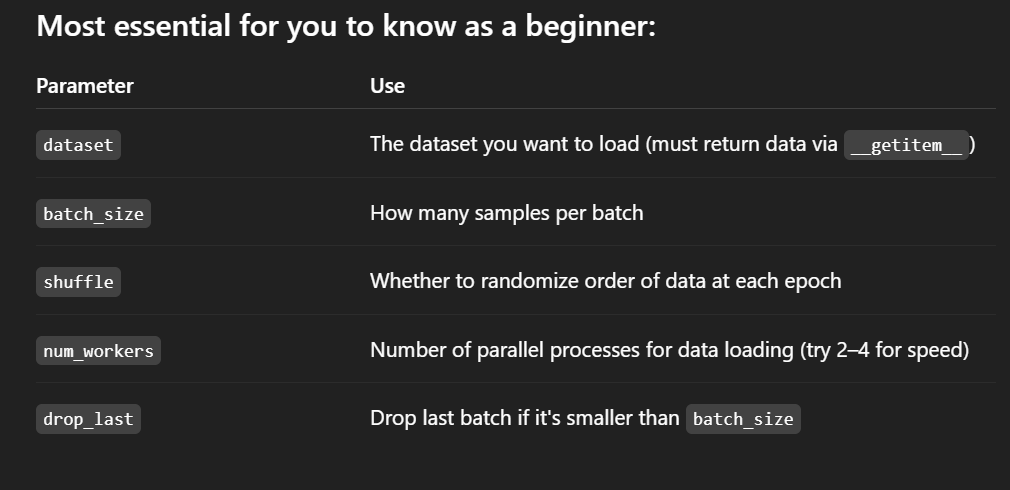

## Let's visualize an image.

The image label: 29 ain
torch.Size([1, 48, 48])


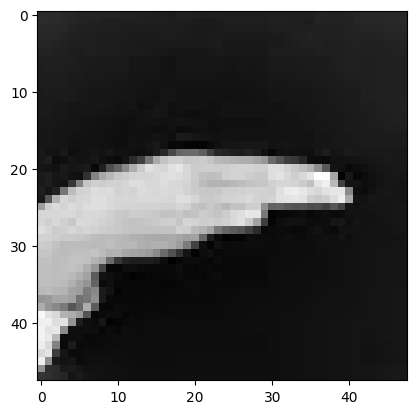

In [12]:
random_img_idx = 30 # Write any random index (between 0 and 59999)

image = train_dataset[random_img_idx][0]  # 0 for image part in (image, label) tuple.
label = train_dataset[random_img_idx][1]  # 1 for label part

print("The image label:", label.item(), mapping[label.item()])

plt.imshow(image.reshape(image.shape[1], image.shape[1]), cmap='gray')

print(image.shape)

### Create a loop to show 10 different images ranodmly

The image label: 12 laam


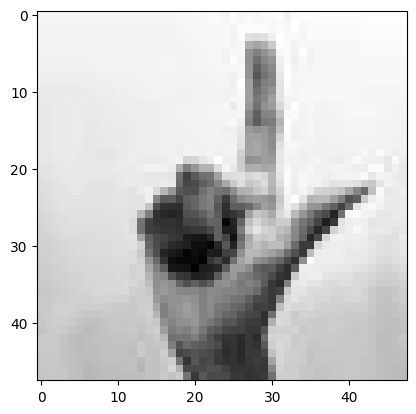

The image label: 22 kaaf


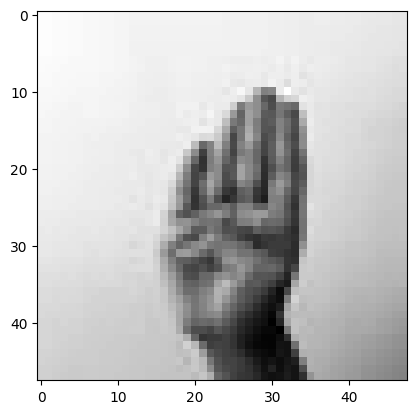

The image label: 30 bb


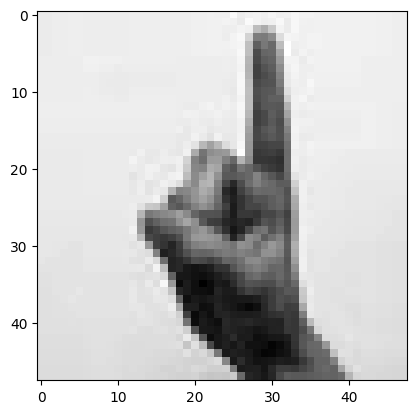

The image label: 1 waw


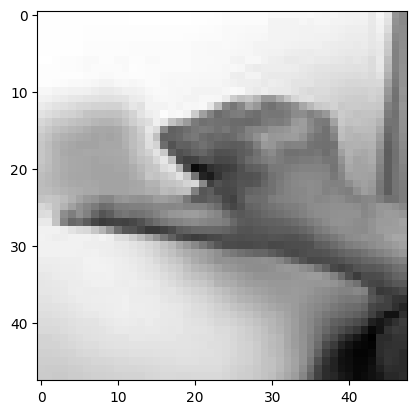

The image label: 1 waw


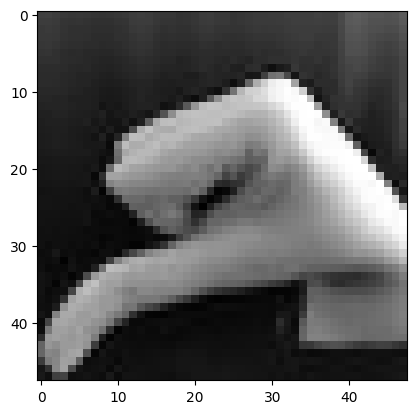

The image label: 18 toot


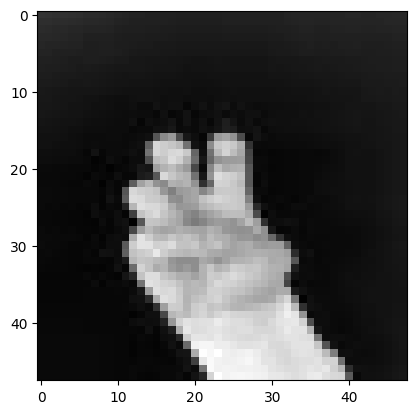

The image label: 24 gaaf


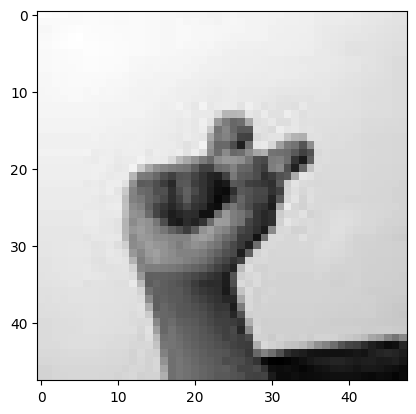

The image label: 19 dal


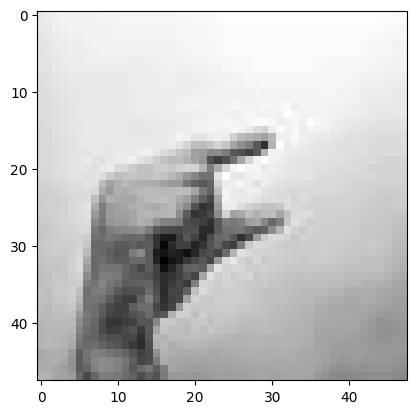

The image label: 18 toot


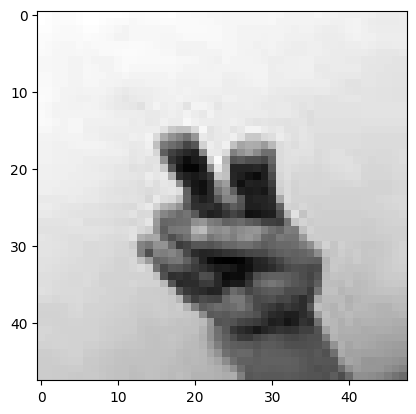

The image label: 7 ya


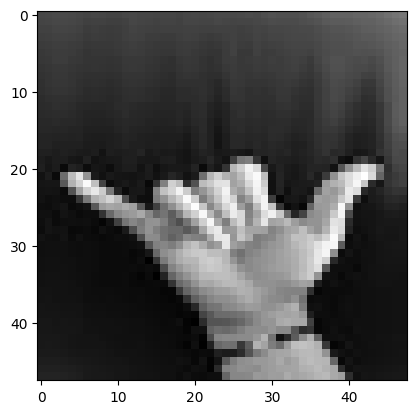

In [17]:
import random
# Show images
for i in range(10):
  random_img_idx=random.randint(0,len(train_dataset)-1)
  image = train_dataset[random_img_idx][0]  # 0 for image part in (image, label) tuple.
  label = train_dataset[random_img_idx][1]  # 1 for label part

  print("The image label:", label.item(), mapping[label.item()])

  plt.imshow(image.reshape(image.shape[1], image.shape[1]), cmap='gray')

  plt.show()# This is the function responsible for displaying the images



###This is the code given in the lab
# plt.figure(figsize=(15, 4))
# for i in range(10):
#     idx = random.randint(0, len(train_dataset)-1)
#     img, label = train_dataset[idx]
#     plt.subplot(1, 10, i+1)
#     plt.imshow(img.permute(1, 2, 0).squeeze(), cmap='gray')
#     plt.title(label)
#     plt.axis('off')
# plt.tight_layout()
# plt.show()

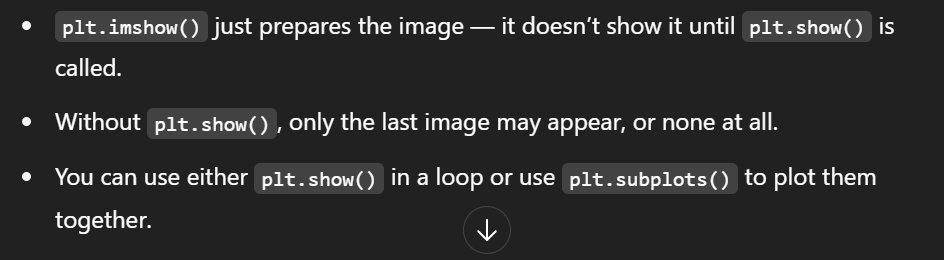

### Create a CNN uisng Pytorch. Then, train the model. Play with the layers to get the best model on the validation data, try to reach a 90% accuracy. At least, make 3 different layers. Also, try different activation functions.

In [13]:
import torch.nn as nn
import torch

# Define the CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Activation
        self.relu = nn.ReLU()

        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 6 * 6, 128) # changed the input into the nn.Linear()
        self.fc2 = nn.Linear(128, 32) #changed the output to 32 according to the number of classes

    def forward(self, x):
        # Convolution + ReLU + Pooling
        x = self.pool(self.relu(self.conv1(x)))  # (Batch, 16, 16, 16)
        x = self.pool(self.relu(self.conv2(x)))  # (Batch, 32, 8, 8)
        x = self.pool(self.relu(self.conv3(x)))  # (Batch, 64, 4, 4)

        # Flatten
        x = x.view(x.size(0), -1)  # (Batch, 64*6*6)

        # Fully Connected Layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)  # Logits

        return x

In [14]:
from tqdm import tqdm    # Shows progress bar

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)


        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss

        optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()

        # Track accuracy
        outputs = torch.softmax(outputs, dim=1)
        predictions = outputs.argmax(dim=1)  # Get class with highest probability
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total  # Compute accuracy in percentage
    return avg_loss, accuracy

# 🔹 Validation Loop
def validate(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            total_loss += loss.item()

            # Compute accuracy
            outputs = torch.softmax(outputs, dim=1)
            predictions = outputs.argmax(dim=1)  # Get predicted class
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total  # Compute accuracy in percentage
    return avg_loss, accuracy


In [15]:
import torch.optim as optim

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class Classification loss (Input: Logits, not probabilities)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
num_epochs = 10 # Number of epochs


# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training process
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Accuracy={train_accuracy:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.2f}%")


100%|██████████| 676/676 [01:41<00:00,  6.68it/s]


Epoch 1/10: Train Loss=1.8138, Train Accuracy=45.93%, Val Loss=0.7517, Val Accuracy=76.02%


100%|██████████| 676/676 [01:44<00:00,  6.44it/s]


Epoch 2/10: Train Loss=0.4990, Train Accuracy=85.50%, Val Loss=0.3545, Val Accuracy=90.43%


100%|██████████| 676/676 [01:44<00:00,  6.48it/s]


Epoch 3/10: Train Loss=0.2874, Train Accuracy=92.32%, Val Loss=0.2806, Val Accuracy=92.58%


100%|██████████| 676/676 [01:44<00:00,  6.47it/s]


Epoch 4/10: Train Loss=0.2036, Train Accuracy=94.60%, Val Loss=0.2167, Val Accuracy=94.69%


100%|██████████| 676/676 [01:42<00:00,  6.58it/s]


Epoch 5/10: Train Loss=0.1651, Train Accuracy=95.48%, Val Loss=0.2049, Val Accuracy=94.80%


100%|██████████| 676/676 [01:43<00:00,  6.54it/s]


Epoch 6/10: Train Loss=0.1350, Train Accuracy=96.16%, Val Loss=0.2022, Val Accuracy=95.40%


100%|██████████| 676/676 [01:43<00:00,  6.54it/s]


Epoch 7/10: Train Loss=0.1127, Train Accuracy=96.69%, Val Loss=0.1937, Val Accuracy=95.19%


100%|██████████| 676/676 [01:43<00:00,  6.52it/s]


Epoch 8/10: Train Loss=0.0915, Train Accuracy=97.28%, Val Loss=0.1828, Val Accuracy=95.80%


100%|██████████| 676/676 [01:44<00:00,  6.46it/s]


Epoch 9/10: Train Loss=0.0824, Train Accuracy=97.57%, Val Loss=0.1996, Val Accuracy=95.44%


100%|██████████| 676/676 [01:43<00:00,  6.52it/s]


Epoch 10/10: Train Loss=0.0705, Train Accuracy=97.81%, Val Loss=0.1914, Val Accuracy=95.81%


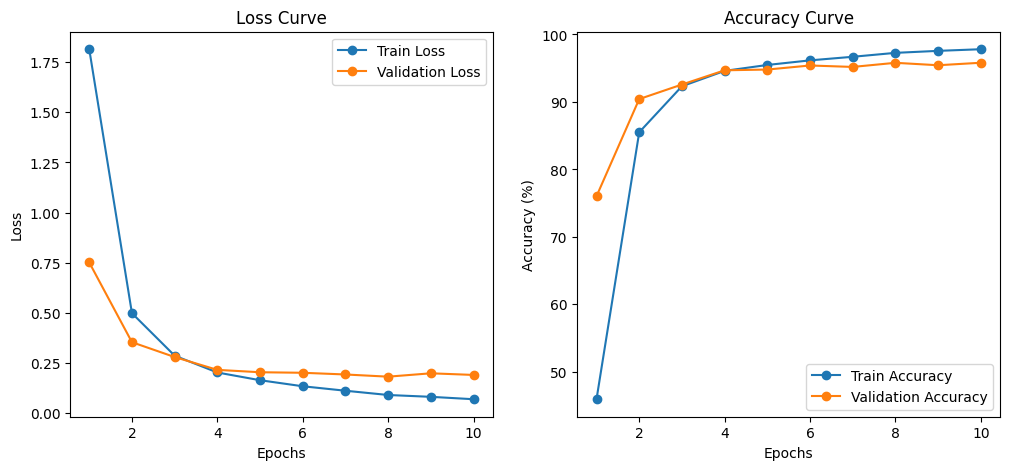

In [16]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


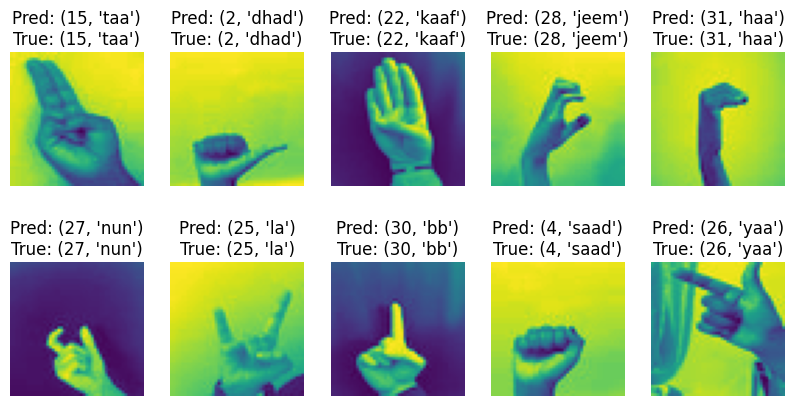

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images with predicted labels
def show_predictions(model, dataloader, device, num_images=10):
    model.eval()  # Set to evaluation mode
    images, labels = next(iter(dataloader))  # Get a batch
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():  # Disable gradient computation
        outputs = model(images)
        predictions = outputs.argmax(dim=1)  # Get predicted class

    classes = list(mapping.items())

    # Plot images with predictions
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i, ax in enumerate(axes.flat[:num_images]):
        img = images[i]
        img = np.transpose(img.cpu().numpy(), (1, 2, 0))  # Convert to (H, W, C)

        ax.imshow(img)
        ax.set_title(f"Pred: {classes[predictions[i].item()]}\nTrue: {classes[labels[i].item()]}")
        ax.axis("off")

    plt.show()

# Show predictions
show_predictions(model, val_loader, device)


# Contributed by: Hassan Alsayhah

![image.png](https://i.imgur.com/a3uAqnb.png)